## Datos

In [1]:
import numpy as np, pandas as pd
import matplotlib as mpl, seaborn as sns
import yfinance as yf
import os, pickle, requests
import random

from matplotlib import pyplot as plt
from scipy import stats

In [2]:
def getData(ticker,data_from,data_to):
    data=yf.download(ticker,auto_adjust=True,progress=False,start=data_from,end=data_to)
    data.rename(columns={'Close':'AdjClose'},inplace=True)
    return data
   

In [3]:
def getPrice(symbol):
    """
    Historical Daily Prices
    Dado un activo (symbol), retorna unicamente su closing price historico (máx 40 years)
    Return: daily dataframe (close)
    """        
    try:
        url='https://financialmodelingprep.com/api/v3/historical-price-full/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p= {'serietype' : 'line','apikey': api_key}
        r=requests.get(url,params=p)
        js=r.json()
        df=pd.DataFrame(js['historical'])
        df.set_index('date',inplace=True)
        df.index=pd.to_datetime(df.index)
        df.rename(columns={'close':'price'},inplace=True)
        df.sort_values('date',ascending=True, inplace=True)
        return df

    except:
        print(symbol,' Historical daily prices not found')

In [4]:
#stock='XOM'
#xom=getPrice(stock)

#path='C:\\Users\\Usuario\\Dataset\\MVP_CF1'
#os.chdir(path)
#xom.to_excel('XOM.xlsx')

In [5]:
path='C:\\Users\\Usuario\\Dataset\\MVP_CF1'
os.chdir(path)

#data=pd.read_excel('KO.xlsx',index_col='date')
#data=pd.read_excel('AAPL.xlsx',index_col='date')
data=pd.read_excel('XOM.xlsx',index_col='date')
data.rename(columns={'price':'AdjClose'},inplace=True)
data.pct_change().mul(100).describe().mean(axis=1)

count    15129.000000
mean         0.036545
std          1.441368
min        -23.428571
25%         -0.710227
50%          0.000000
75%          0.782779
max         17.910448
dtype: float64

### Filtro de datos (QC)

Validar los datos a utilizar en relación a:

* dividendos / splits
* spikes
* son todos activos de un mismo sector / high-low beta
* survivorship bias
* QC datos (utlizar data profiler)

## Data Mining

Intenta buscar patrones que nos den algún tipo de señal, esto es, se agregan indicadores / features y se analizan las correlaciones contra el target (precio / futuro retorno del mismo), de manera de generarme algún tipo de clasificación diferenciable (ML)

Podemos agregar indicadores de cruces de media, indicadores técnicos (RSI), osciladores (MACD), paramétricos de la distribución del target (sigma, skew, kurtosis)

In [6]:
def addCRUCE(data,fast,slow):
    data[f'SMA_{fast}']=data.AdjClose.rolling(fast).mean()
    data[f'SMA_{slow}']=data.AdjClose.rolling(slow).mean()
    data[f'Cruce_{fast}_{slow}']=data[f'SMA_{fast}']/data[f'SMA_{slow}']-1
    return data

In [7]:
def addRSI(data, ruedas, ruedas_pend=0):
    '''
    Agrega la columna RSI a nuestro dataframe, basado en su columna adjusted_close
    |    
    |_ data:  dataframe
    |
    |_ ruedas: integer, La cantidad de ruedas para el cálculo del RSI
    |
    |_ ruedas_pend : integer, opcional (Cantidad de ruedas para calcular pendiente del RSI y su divergencia)
    '''
    import numpy as np
    df = data.copy()
    df['dif'] = df.AdjClose.diff()
    df['win'] = np.where(df['dif'] > 0, df['dif'], 0)
    df['loss'] = np.where(df['dif'] < 0, abs(df['dif']), 0)
    df['ema_win'] = df.win.ewm(alpha=1/ruedas).mean()
    df['ema_loss'] = df.loss.ewm(alpha=1/ruedas).mean()
    df['rs'] = df.ema_win / df.ema_loss
    data['rsi'] = 100 - (100 / (1+df.rs))

    if ruedas_pend != 0:
        data['rsi_pend'] = (data.rsi/data.rsi.shift(ruedas_pend)-1)*100
        precio_pend = (data.AdjClose/data.AdjClose.shift(ruedas_pend)-1)*100
        data['rsi_div'] = data.rsi_pend * precio_pend
    return data

In [8]:
def addFW(data, n):
    data['fw_'+str(n)] = (data.AdjClose.shift(-n) / data.AdjClose -1)*100
    return data

In [9]:
def addSIGMA(data, n):
    data['variacion']=data.AdjClose.pct_change()*100
    data['sigma_'+str(n)] = data.AdjClose.pct_change().rolling(n).std()
    #data_aux=data.AdjClose.pct_change()*100
    #data['sigma_'+str(n)] = data_aux.rolling(n).std()*(n**0.5)
    return data

In [10]:
def getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60):
    data['Balance']=np.where(data.AdjClose>data.AdjClose.shift(),data['Volume'],np.where(data.AdjClose<data.AdjClose.shift(),-data['Volume'],0))
    data['OBV']=data['Balance'].cumsum()
    dif=data['AdjClose'].diff()
    win=pd.DataFrame(np.where(dif>0,dif,0),index=data.index)
    loss=pd.DataFrame(np.where(dif<0,abs(dif),0),index=data.index)
    ema_win=win.ewm(alpha=1/n_rsi).mean()
    ema_loss=loss.ewm(alpha=1/n_rsi).mean()
    rs=ema_win/ema_loss

    data['cruce']=data.AdjClose.rolling(fast).mean() / data.AdjClose.rolling(slow).mean() - 1
    data['rsi']=100 - (100/(1+rs))
    data['sigma']=data.AdjClose.pct_change().rolling(n_sigma).std()
    data['OBV_osc']=(data.OBV - data.OBV.rolling(n_obv).mean()) / (data.OBV.rolling(n_obv).std())
    features=data.iloc[:,-4:].dropna()
    return features



In [11]:
def getFeaturesbyADD(data,n_sigma,n_rsi,fast,slow):
    data['cruce']=addCRUCE(data,fast,slow)[f'Cruce_{fast}_{slow}']
    data['rsi']=addRSI(data, n_rsi, ruedas_pend=0)['rsi']
    data['sigma']=addSIGMA(data,n_sigma)['sigma_'+str(n_sigma)]
    cols=['cruce','rsi','sigma'] 
    features=data.loc[:,cols].dropna()
    return features

### Correlacion features versus variacion

In [12]:
data=pd.read_excel('XOM.xlsx',index_col='date')
data.rename(columns={'price':'AdjClose'},inplace=True)

ruedas=14
fast,slow=20,60 # dias
sigma=40 # dias

addCRUCE(data,fast,slow)
addRSI(data,ruedas)
addSIGMA(data,sigma)

cols=['AdjClose',f'Cruce_{fast}_{slow}','rsi',f'sigma_{sigma}','variacion'] # features de interes
data=data.loc[:,cols].dropna().round(4)

data.iloc[:,1:-1]=data.iloc[:,1:-1].shift() # Adelanto una fila los indicadores para remover el look ahead bias

In [13]:
features=[f'Cruce_{fast}_{slow}','rsi',f'sigma_{sigma}']
for feature in features:
    r2=data[feature].corr(data.variacion)
    print(f"El r2 con feature {feature} es {r2:.2f}")


El r2 con feature Cruce_20_60 es -0.02
El r2 con feature rsi es -0.04
El r2 con feature sigma_40 es 0.02


[(-10.0, 10.0)]

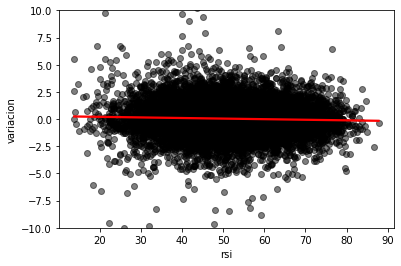

In [14]:
g=sns.regplot(x="rsi",y="variacion",data=data,line_kws={"color":"red"},scatter_kws={"color":"k","alpha":.5})
g.set(ylim=(-10,10))

### Correlacion features versus forwards

In [15]:
data=pd.read_excel('XOM.xlsx',index_col='date')
data.rename(columns={'price':'AdjClose'},inplace=True)

ruedas=14
fast,slow=20,60 # dias
sigma=40 # dias

addCRUCE(data,fast,slow)
addRSI(data,ruedas)
addSIGMA(data,sigma)
addFW(data,10)
addFW(data,20)

cols=['AdjClose',f'Cruce_{fast}_{slow}','rsi',f'sigma_{sigma}','variacion','fw_10','fw_20'] # features de interes
data=data.loc[:,cols].dropna().round(4)

data.iloc[:,1:-1]=data.iloc[:,1:-1].shift() # Adelanto una fila los indicadores para remover el look ahead bias

In [16]:
features=[f'Cruce_{fast}_{slow}','rsi',f'sigma_{sigma}']
data.corr().loc[['fw_10','fw_20'],features].round(2)

,Cruce_20_60,rsi,sigma_40
fw_10,-0.06,-0.07,0.06
fw_20,-0.06,-0.07,0.08


### Clasificaciones diferenciables

In [17]:
data['variacion_tipo']=np.where(data.variacion>0,'Up','Down')
medias=data.groupby('variacion_tipo').mean().loc[:,features].round(2)
desvios=data.groupby('variacion_tipo').std().loc[:,features].round(2)

print(f'Medias segun clasificacion de Variacion \n {medias} \n')
print(f'Desvios segun clasificacion de Variacion \n {desvios} \n')


Medias segun clasificacion de Variacion 
                 Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   0.00  48.44      0.01
Up                     0.01  54.99      0.01 

Desvios segun clasificacion de Variacion 
                 Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   0.03  10.62      0.01
Up                     0.03  10.26      0.01 



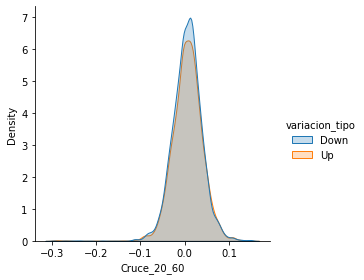

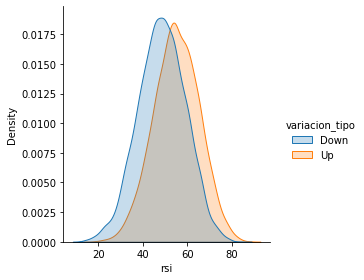

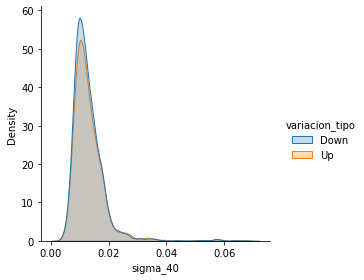

In [18]:
for feature in features:
    sns.displot(data,x=feature,hue="variacion_tipo",kind="kde",height=4,fill=True)

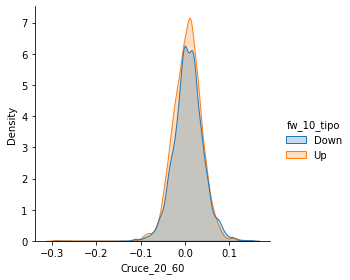

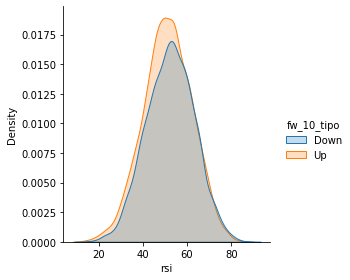

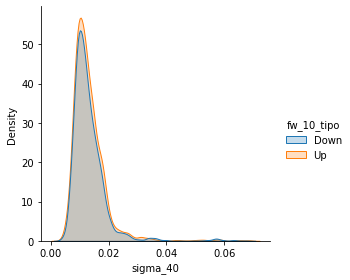

In [19]:
data['fw_10_tipo']=np.where(data.fw_10>0,'Up','Down')
#medias=data.groupby('fw_10_tipo').mean().loc[:,features].round(2)
#desvios=data.groupby('fw_10_tipo').std().loc[:,features].round(2)

#print(f'Medias segun clasificacion de Variacion \n {medias} \n')
#print(f'Desvios segun clasificacion de Variacion \n {desvios} \n')
for feature in features:
    sns.displot(data,x=feature,hue="fw_10_tipo",kind="kde",height=4,fill=True)

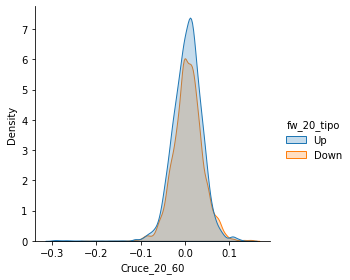

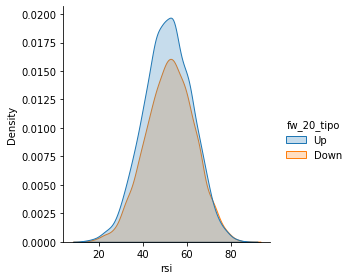

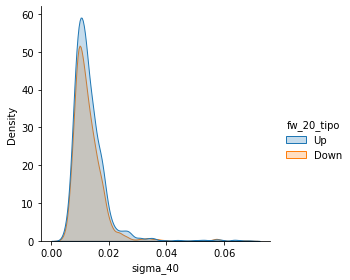

In [20]:
data['fw_20_tipo']=np.where(data.fw_20>0,'Up','Down')
#medias=data.groupby('fw_20_tipo').mean().loc[:,features].round(2)
#desvios=data.groupby('fw_20_tipo').std().loc[:,features].round(2)

#print(f'Medias segun clasificacion de Variacion \n {medias} \n')
#print(f'Desvios segun clasificacion de Variacion \n {desvios} \n')
for feature in features:
    sns.displot(data,x=feature,hue="fw_20_tipo",kind="kde",height=4,fill=True)

### Introspección de features

Permite focalizar el esfuerzo en los mejores features que aporten valor, es decir, los que menos confusión pudieran generar.

#### 1) Relevancia de todos los features

In [21]:
data=pd.read_excel('XOM.xlsx',index_col='date')
data.rename(columns={'price':'AdjClose'},inplace=True)

In [22]:
ruedas=14
fast,slow=20,60 # dias
sigma=40 # dias

addCRUCE(data,fast,slow)
addRSI(data,ruedas)
addSIGMA(data,sigma)

addFW(data,10)

cols=[f'Cruce_{fast}_{slow}','rsi',f'sigma_{sigma}','fw_10']
data=data.loc[:,cols].dropna().round(4)

data.iloc[:,1:-1]=data.iloc[:,1:-1].shift()

In [23]:
print(data.corr()['fw_10'])
print('Promedio= ',data.corr()['fw_10'][:-1].abs().mean())

Cruce_20_60   -0.056354
rsi           -0.055514
sigma_40       0.057717
fw_10          1.000000
Name: fw_10, dtype: float64
Promedio=  0.0565282536550645


#### 2) Multicolinealidad

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=data.iloc[:,:-1].dropna()
cols=X.columns
vif=[variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
pd.DataFrame(zip(cols,vif), columns=['feature','VIF']).set_index('feature')

,VIF
feature,
Cruce_20_60,1.212394
rsi,5.291893
sigma_40,4.996495


<AxesSubplot:>

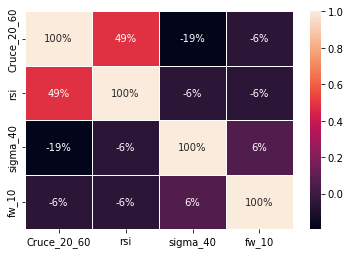

In [25]:
sns.heatmap(data.corr(),annot=True,fmt='.0%',linewidths=1)

#### 3) Autoregresión

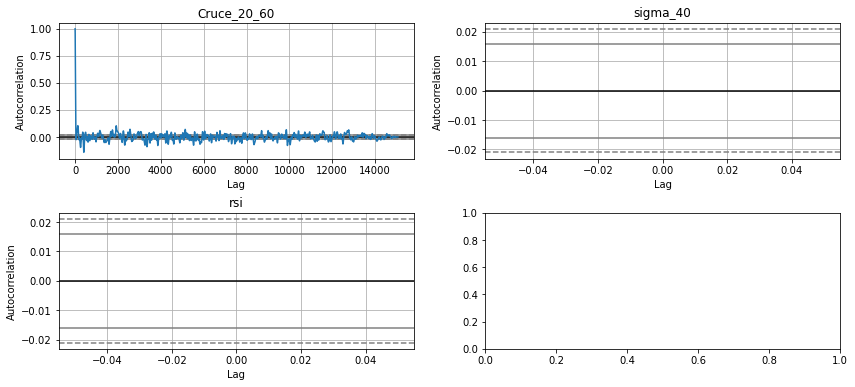

In [26]:
n_rows=2
n_cols=len(data.columns)//2

fig,ax=plt.subplots(figsize=(14,6),ncols=n_cols,nrows=n_rows)

for i, col in enumerate(data.columns[:-1]):
    r=i%2
    c=i//2
    pd.plotting.autocorrelation_plot(data[col],ax=ax[r][c])
    ax[r][c].set_title(col)

plt.subplots_adjust(hspace=0.4)

#### 4) Distribuciones

Es importante saber que tipo de distribución se corresponde con cada feature y el target, de modo de parametrizarlas para luego modelar simulaciones.

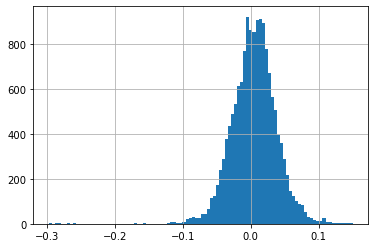

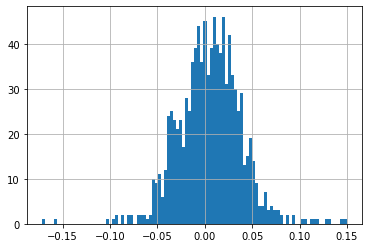

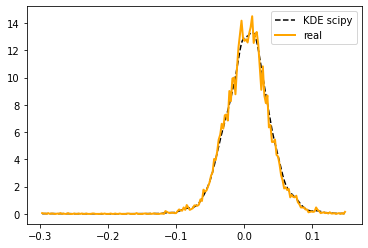

In [30]:
data['Cruce_20_60'].hist(bins=100,figsize=(6,4))
plt.suptitle('')
plt.show()

kde=stats.gaussian_kde(data['Cruce_20_60'])
resampleo=kde.resample(size=1000)[0]
pd.Series(resampleo).hist(bins=100)
x_eval=np.linspace(min(data['Cruce_20_60']),max(data['Cruce_20_60']),len(data['Cruce_20_60']))
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(x_eval,kde(x_eval),'k--',label='KDE scipy')
count,division=np.histogram(data['Cruce_20_60'],density=True,bins=200)
ax.plot(division[:-1],count,lw=2,color='orange',label='real')
ax.legend()

#### 5) Balanceo / Desbalanceo

Busco eventos de probabilidades menores al 10%, que es muy útil operando con un screener, de otra manera es complicado de capturar.

In [31]:
data['Cruce_20_60'].corr(data['fw_10']) # es la correlación de toda la serie

-0.05635402201872296

In [32]:
corte=int(data['Cruce_20_60'].count()/10) # Corte de 10%
primer_decil=data.sort_values('Cruce_20_60',ascending=True).iloc[:corte]
print('Primer decil con corte de 10% ',primer_decil['Cruce_20_60'].corr(primer_decil['fw_10']))

ultimo_decil=data.sort_values('Cruce_20_60',ascending=False).iloc[:corte]
print('Ultimo decil con corte de 10% ',ultimo_decil['Cruce_20_60'].corr(ultimo_decil['fw_10']))

Primer decil con corte de 10%  -0.1141188834450137
Ultimo decil con corte de 10%  -0.026381495734866083


## Composición del trade

En este caso , y dado los features, con lógica definida de trade definimos las acciones, a partir de lo cual podemos backtestear.


### Señales de compra / venta

Una vez armada la matriz de features, se procede a armar la matriz de gatillos vía máscaras, la cual es una condición asociada a una o más columnas (de los features), en este caso definimos:

* compra
1) cruce de medias > 0
2) RSI (ventana de 15 velas) > 65
3) volatilidad diaria (ventana 40 velas) > 1%

* venta
1) cruce de medias < -1%
2) RSI (ventana de 15 velas) < 55
3) oscilador OBV > 0

In [33]:
def getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0):
    gatillos_compra=pd.DataFrame(index=features.index)
    gatillos_compra['cruce']=np.where(features.cruce>trig_buy_cross,True,False)
    gatillos_compra['rsi']=np.where(features.rsi>trig_buy_rsi,True,False)
    gatillos_compra['sigma']=np.where(features.sigma>trig_buy_sigma,True,False)
    mascara_compra=gatillos_compra.all(axis=1)

    gatillos_venta=pd.DataFrame(index=features.index)
    gatillos_venta['cruce']=np.where(features.cruce<trig_sell_cross,True,False)
    gatillos_venta['rsi']=np.where(features.rsi<trig_sell_rsi,True,False)
    gatillos_venta['obv']=np.where(features.OBV_osc > trig_sell_obv,True,False)
    mascara_venta=gatillos_venta.all(axis=1)

    data_aux=data.copy().dropna()
    data_aux['gatillo']=np.where(mascara_compra,'compra',np.where(mascara_venta,'venta',''))
    actions=data_aux.loc[data_aux.gatillo !=''].copy()

    actions['gatillo']=np.where(actions.gatillo != actions.gatillo.shift(),actions.gatillo,'')
    actions=actions.loc[actions.gatillo != ''].copy()

    if actions.iloc[0].loc['gatillo'] == 'venta':
        actions=actions.iloc[1:]
    if actions.iloc[-1].loc['gatillo'] == 'compra':
        actions=actions.iloc[:-1]
    
    return actions

In [34]:
def getTrades(actions):
    pares=actions.iloc[::2].loc[:,['AdjClose']].reset_index()
    impares=actions.iloc[1::2].loc[:,['AdjClose']].reset_index()
    trades=pd.concat([pares,impares],axis=1)

    CT=0
    trades.columns=['fecha_compra','px_compra','fecha_venta','px_venta']
    trades['rendimiento']=trades.px_venta/trades.px_compra - 1
    trades['rendimiento'] -= CT
    trades['dias']=(trades.fecha_venta-trades.fecha_compra).dt.days

    if len(trades):
        trades['resultado']=np.where(trades['rendimiento'] > 0 , 'Ganador','Perdedor')
        trades['rendimientoAcumulado']=(trades['rendimiento']+1).cumprod()-1
    
    return trades

In [35]:
def resumen(trades):
    if len(trades):
        resultado=float(trades.iloc[-1:].rendimientoAcumulado-1)
        agg_cant=trades.groupby('resultado').size()
        agg_rend=trades.groupby('resultado').mean()['rendimiento']
        agg_tiempos=trades.groupby('resultado').sum()['dias']
        agg_tiempos_medio=trades.groupby('resultado').mean()['dias']


        r=pd.concat([agg_cant,agg_rend,agg_tiempos,agg_tiempos_medio],axis=1)
        r.columns=['Cantidad','Rendimiento x Trade','Dias Total','Dias x Trade']
        resumen=r.T

        try: t_win=r['Dias Total']['Ganador']
        except: t_win=0

        try: t_loss=r['Dias Total']['Perdedor']
        except: t_loss=0 
        
        t=t_win+t_loss
        tea=(resultado+1)**(365/t)-1 if t > 0 else 0

        metricas={'rendimiento':round(resultado,4),'dias_in':round(t,4),'TEA':round(tea,4)}
    else:
        resumen=pd.DataFrame()
        metricas={'rendimiento':0,'dias_in':0,'TEA':0}

    return resumen,metricas
        

In [36]:
def plotControl(data, actions):
        
        df = data.iloc[:]
        compras = actions.loc[actions.gatillo == 'compra']
        ventas = actions.loc[actions.gatillo == 'venta']

        fig, ax = plt.subplots(figsize=(12, 6))

        ax.plot(df.AdjClose, '--k', alpha=0.4, lw=1, label='Precio')

        ax.plot(compras.AdjClose * 0.95, marker='^', lw=0,markersize=10, color='k', label='Compras')
        ax.plot(ventas.AdjClose * 0.95, marker='v', lw=0,markersize=10, color='red', label='Ventas')
        ax.legend()
        ax.set_yscale('log')
        ax.grid(axis='both')

        return


In [37]:
data=getData(ticker='TSLA',data_from='2011-01-01',data_to='2020-12-31')
features=getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60)
actions=getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0)
trades=getTrades(actions)
resumen(trades)

(resultado                Ganador    Perdedor
 Cantidad                7.000000    4.000000
 Rendimiento x Trade     0.922483   -0.074515
 Dias Total           1606.000000  692.000000
 Dias x Trade          229.428571  173.000000,
 {'rendimiento': 29.8979, 'dias_in': 2298, 'TEA': 0.7245})

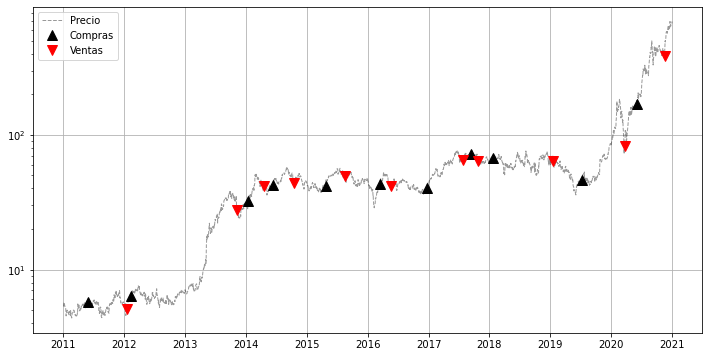

In [38]:
plotControl(data,actions)

## Parametrizacion

* Parametrizacion de features
* Parametrizacion de gatillos
* PCA

Clave es minimizar la varianza de los parametros en las simulaciones, y no tanto maximizar TEA.

### Parametrizacion de features

Se trata de buscar una zona óptima clara (no un valor sino una zona de valores similares), una zona no tan sensible, coherencia (si se quiere maximizar tasa y reducir tiemp invertido, se usará el mismo criterio en todos los parámetros)

In [39]:
#CONTROL
data=getData(ticker='TSLA',data_from='2011-01-01',data_to='2020-12-31')
features=getFeatures(data,n_obv=100,n_sigma=40,n_rsi=15,fast=20,slow=60)
actions=getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0)
trades=getTrades(actions)
resumen(trades)

(resultado                Ganador    Perdedor
 Cantidad                7.000000    4.000000
 Rendimiento x Trade     0.922483   -0.074515
 Dias Total           1606.000000  692.000000
 Dias x Trade          229.428571  173.000000,
 {'rendimiento': 29.8979, 'dias_in': 2298, 'TEA': 0.7245})

In [40]:
# Optimizo el RSI (original de 15 velas)
l=[]
for i in range(5,120):
    features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=i,fast=20,slow=60)
    actions=getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0)
    trades=getTrades(actions)
    resultados_df,resultados_dict=resumen(trades)
    resultados_dict['ventana_RSI']=i
    l.append(resultados_dict)

results=pd.DataFrame(l)
results

,rendimiento,dias_in,TEA,ventana_RSI
0,20.1139,2714,0.5071,5
1,21.0241,2699,0.5192,6
2,21.8261,2683,0.5304,7
3,29.2967,2524,0.6377,8
4,22.6452,2483,0.5920,9
...,...,...,...,...
110,-0.5491,251,-0.6859,115
111,-0.6297,243,-0.7751,116
112,-0.6297,243,-0.7751,117
113,-0.6297,243,-0.7751,118


Text(0.5, 1.0, 'Parametrización RSI')

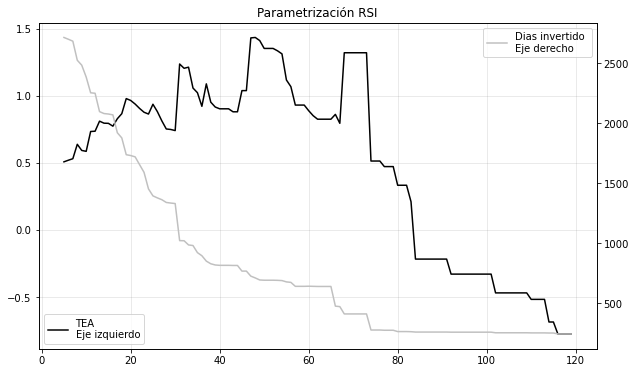

In [41]:
fig,ax=plt.subplots(figsize=(10,6))
ax.plot(results.ventana_RSI,results.TEA,color='k',label='TEA \nEje izquierdo')
ax.legend(loc='lower left')
ax.grid(color='gray',alpha=0.2)

ax2=ax.twinx()
ax2.plot(results.ventana_RSI,results.dias_in,color='silver',label='Dias invertido \nEje derecho')
ax2.legend(loc='upper right')

ax.set_title('Parametrización RSI')


In [42]:
# Optimizo el OBV (original de 100 velas)
l=[]
for i in range(10,250):
    features=getFeatures(data,n_obv=i,n_sigma=40,n_rsi=15,fast=20,slow=60)
    actions=getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0)
    trades=getTrades(actions)
    resultados_df,resultados_dict=resumen(trades)
    resultados_dict['ventana_OBV']=i
    l.append(resultados_dict)

results=pd.DataFrame(l)
results

,rendimiento,dias_in,TEA,ventana_OBV
0,4.9733,1774,0.4445,10
1,5.1152,1786,0.4478,11
2,5.2365,1790,0.4524,12
3,5.2796,1793,0.4536,13
4,5.2796,1793,0.4536,14
...,...,...,...,...
235,18.7452,2191,0.6437,245
236,18.7452,2191,0.6437,246
237,16.5207,2375,0.5528,247
238,16.5207,2375,0.5528,248


Text(0.5, 1.0, 'Parametrización OBV')

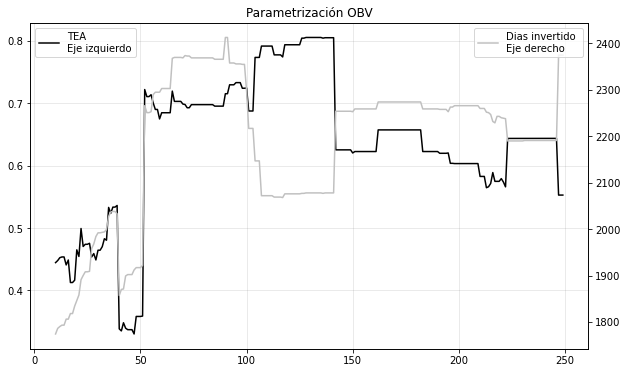

In [43]:
fig,ax=plt.subplots(figsize=(10,6))
ax.plot(results.ventana_OBV,results.TEA,color='k',label='TEA \nEje izquierdo')
ax.legend(loc='upper left')
ax.grid(color='gray',alpha=0.2)

ax2=ax.twinx()
ax2.plot(results.ventana_OBV,results.dias_in,color='silver',label='Dias invertido \nEje derecho')
ax2.legend(loc='upper right')

ax.set_title('Parametrización OBV')


In [44]:
# Optimizo SMA  (original de fast=20 y slow=60)
l=[]
for fast in range(5,50):
    for slow in range(fast+1,fast+100,5):
        print(f'Cruce: {fast} - {slow}       ',end='\r')
        features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=50,fast=fast,slow=slow)
        actions=getActions(features,trig_buy_cross=0,trig_buy_rsi=65,trig_buy_sigma=0.01,trig_sell_cross=-0.01,trig_sell_rsi=55,trig_sell_obv=0)
        trades=getTrades(actions)
        resultados_df,resultados_dict=resumen(trades)
        resultados_dict['fast']=fast
        resultados_dict['slow']=slow
        l.append(resultados_dict)

results=pd.DataFrame(l)
results

,rendimiento,dias_in,TEA,fast,slow
0,5.6814,556,2.4794,5,6
1,4.5001,514,2.3554,5,11
2,5.9924,564,2.5206,5,16
3,6.0690,572,2.4833,5,21
4,6.0690,572,2.4833,5,26
...,...,...,...,...,...
895,0.5488,1259,0.1352,49,125
896,0.7610,1262,0.1778,49,130
897,0.7304,1270,0.1707,49,135
898,0.6944,1271,0.1635,49,140


In [45]:
top20=results.dropna().sort_values('TEA',ascending=False).head(20)
top20
top20.describe().iloc[1:3,3:]

,fast,slow
mean,8.950000,20.20000
std,4.135533,6.36272


### Parametrización de gatillos

Lo más importante nos es maximizar TEA, sino minimizar la varianza de los parámetros en las simulaciones.

In [46]:
# Seleccionar rangos en función de la variablidad de cada feature

samples={'trig_buy_sigma': [i/500 for i in range(20)],
        'trig_buy_rsi': [i for i in range(50,75)],  
        'trig_buy_cross': [-0.05 + i/100 for i in range(20)],
        'trig_sell_rsi': [i for i in range(40,60)],
        'trig_sell_cross': [-0.1 +i/100 for i in range(20)],
        'trig_sell_obv': [-2 + i/10 for i in range(40)]  }

def getTriggers():
    triggers={}
    for key in samples.keys():
        triggers[key]=round(random.choice(samples[key]),4)
    return triggers


In [47]:
features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=45,fast=15,slow=30)

l=[]
for sample in range(5000):

    triggers=getTriggers()
    actions=getActions(features, trig_buy_cross=triggers['trig_buy_cross'],
                                trig_buy_rsi=triggers['trig_buy_rsi'],
                                trig_buy_sigma=triggers['trig_buy_sigma'],
                                trig_sell_cross=triggers['trig_sell_cross'],
                                trig_sell_rsi=triggers['trig_sell_rsi'],
                                trig_sell_obv=triggers['trig_sell_obv'])
    
    trades=getTrades(actions)
    resultados_df,resultados_dict=resumen(trades)

    for key in samples.keys():
        resultados_dict[key]=triggers[key]
    
    l.append(resultados_dict)

results=pd.DataFrame(l)
results


C:\Users\Usuario\AppData\Local\Temp/ipykernel_16912/3735402372.py:21: RuntimeWarning: invalid value encountered in double_scalars
  tea=(resultado+1)**(365/t)-1 if t > 0 else 0


,rendimiento,dias_in,TEA,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
0,-0.0788,1010,-0.0292,0.038,62,0.13,41,0.02,-1.0
1,-1.3587,233,NaN,0.014,67,0.13,44,-0.05,-1.9
2,44.9596,2524,0.7394,0.006,58,-0.05,54,0.06,1.4
3,18.0830,574,5.5215,0.038,57,0.01,59,0.05,-1.9
4,5.3869,470,3.2207,0.028,66,0.07,53,0.06,-1.0
...,...,...,...,...,...,...,...,...,...
4995,10.8728,530,4.4957,0.014,72,-0.03,59,0.09,1.8
4996,0.0000,0,0.0000,0.012,53,-0.05,48,0.06,1.8
4997,0.5385,1012,0.1681,0.038,66,-0.04,41,0.05,-1.6
4998,1.7333,1523,0.2725,0.000,65,0.14,53,-0.03,1.8


In [48]:
top20=results.dropna().sort_values('TEA',ascending=False).head(20)
top20
top20.describe().iloc[1:3,3:]

,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
mean,0.031400,60.100000,0.01250,57.400000,0.031500,-0.560000
std,0.008732,3.596782,0.05665,1.698296,0.033131,0.784991


In [49]:
# Recalculo con los hiperparámetros optimizados por TEA
# Consecuentemente la TEA incrementa desde 0.7245 a 4.5149

data=getData(ticker='TSLA',data_from='2011-01-01',data_to='2020-12-31')
features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=45,fast=15,slow=30)
actions=getActions(features,trig_buy_cross=0.031,trig_buy_rsi=57.55,trig_buy_sigma=0.0295,trig_sell_cross=0.0435,trig_sell_rsi=57.55,trig_sell_obv=-0.34)
trades=getTrades(actions)
resultados_df,resultados_dict=resumen(trades)
resultados_dict

{'rendimiento': 18.5014, 'dias_in': 635, 'TEA': 4.5149}

In [50]:
# Sampleo utilizando los parámetros del top20

keys=top20.iloc[:,3:].columns
samples={}
for k in keys:
    samples[k]=stats.norm(top20[k].mean(),top20[k].std()).rvs(400)

def getTriggers():
    triggers={}
    for key in samples.keys():
        triggers[key]=round(random.choice(samples[key]),4)
    
    return triggers

getTriggers()

{'trig_buy_sigma': 0.0387,
 'trig_buy_rsi': 62.3296,
 'trig_buy_cross': 0.0166,
 'trig_sell_rsi': 60.8,
 'trig_sell_cross': 0.043,
 'trig_sell_obv': 0.3131}

In [51]:
features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=45,fast=15,slow=30)

l=[]
for sample in range(5000):

    triggers=getTriggers()
    actions=getActions(features, trig_buy_cross=triggers['trig_buy_cross'],
                                trig_buy_rsi=triggers['trig_buy_rsi'],
                                trig_buy_sigma=triggers['trig_buy_sigma'],
                                trig_sell_cross=triggers['trig_sell_cross'],
                                trig_sell_rsi=triggers['trig_sell_rsi'],
                                trig_sell_obv=triggers['trig_sell_obv'])
    
    trades=getTrades(actions)
    resultados_df,resultados_dict=resumen(trades)

    for key in samples.keys():
        resultados_dict[key]=triggers[key]
    
    l.append(resultados_dict)

results=pd.DataFrame(l)
results


C:\Users\Usuario\AppData\Local\Temp/ipykernel_16912/3735402372.py:21: RuntimeWarning: invalid value encountered in double_scalars
  tea=(resultado+1)**(365/t)-1 if t > 0 else 0


,rendimiento,dias_in,TEA,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
0,18.9389,653,4.3270,0.0363,57.0255,0.0110,58.3067,0.0006,-0.7744
1,9.4740,695,2.4335,0.0191,59.7145,0.0531,56.6332,0.0409,-1.0696
2,6.3474,479,3.5709,0.0236,64.3123,0.0359,55.9978,0.0678,-1.1030
3,10.7914,660,2.9139,0.0291,56.8240,0.0822,57.8285,-0.0048,0.1867
4,1.9899,338,2.2633,0.0403,61.7699,-0.0243,57.8519,0.0176,-1.6060
...,...,...,...,...,...,...,...,...,...
4995,9.9017,544,3.9672,0.0148,60.6213,0.0838,56.0819,0.0218,0.9721
4996,0.7504,312,0.9250,0.0398,63.8011,-0.0009,54.9804,0.0880,-0.2671
4997,9.3079,469,5.1447,0.0281,62.8933,-0.0073,60.1994,0.0163,-0.6549
4998,2.4454,427,1.8790,0.0386,59.0648,0.0273,55.6308,-0.0415,-1.5338


In [52]:
top20=results.dropna().sort_values('TEA',ascending=False).head(20)
top20
top20.describe().iloc[1:3,3:]

,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
mean,0.031810,60.754295,-0.014670,58.957685,0.07405,-0.593830
std,0.003513,0.826937,0.050503,1.359552,0.02248,0.771699


In [53]:
# Sampleo utilizando los parámetros del top20

keys=top20.iloc[:,3:].columns
samples={}
for k in keys:
    samples[k]=stats.norm(top20[k].mean(),top20[k].std()).rvs(400)

def getTriggers():
    triggers={}
    for key in samples.keys():
        triggers[key]=round(random.choice(samples[key]),4)
    
    return triggers

getTriggers()

{'trig_buy_sigma': 0.0264,
 'trig_buy_rsi': 61.3048,
 'trig_buy_cross': 0.0146,
 'trig_sell_rsi': 58.6967,
 'trig_sell_cross': 0.0459,
 'trig_sell_obv': -1.1032}

In [54]:
features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=45,fast=15,slow=30)

l=[]
for sample in range(5000):

    triggers=getTriggers()
    actions=getActions(features, trig_buy_cross=triggers['trig_buy_cross'],
                                trig_buy_rsi=triggers['trig_buy_rsi'],
                                trig_buy_sigma=triggers['trig_buy_sigma'],
                                trig_sell_cross=triggers['trig_sell_cross'],
                                trig_sell_rsi=triggers['trig_sell_rsi'],
                                trig_sell_obv=triggers['trig_sell_obv'])
    
    trades=getTrades(actions)
    resultados_df,resultados_dict=resumen(trades)

    for key in samples.keys():
        resultados_dict[key]=triggers[key]
    
    l.append(resultados_dict)

results=pd.DataFrame(l)
results


C:\Users\Usuario\AppData\Local\Temp/ipykernel_16912/3735402372.py:21: RuntimeWarning: invalid value encountered in double_scalars
  tea=(resultado+1)**(365/t)-1 if t > 0 else 0


,rendimiento,dias_in,TEA,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
0,13.3938,456,7.4537,0.0325,60.4486,-0.0135,58.3895,0.0674,-1.9221
1,11.1732,531,4.5730,0.0309,60.4931,-0.0266,58.6306,0.0874,0.9777
2,10.3659,446,6.3095,0.0307,60.7995,-0.0695,58.6306,0.0806,-0.4707
3,11.5379,485,5.7065,0.0334,60.9060,-0.0201,59.6193,0.0348,-0.4136
4,14.4580,476,7.1630,0.0332,60.9060,0.0296,57.7466,0.0759,0.2477
...,...,...,...,...,...,...,...,...,...
4995,1.7386,367,1.7236,0.0351,60.4566,0.0417,60.0267,0.0955,0.4878
4996,12.6159,484,6.1651,0.0346,60.5404,-0.1053,59.3962,0.0392,-0.4957
4997,12.2958,526,5.0223,0.0309,60.1429,-0.1047,55.5133,0.0715,-1.3337
4998,10.7080,470,5.7574,0.0289,61.5918,-0.0086,59.9575,0.0424,0.5760


In [55]:
top20=results.dropna().sort_values('TEA',ascending=False).head(20)
top20
top20.describe().iloc[1:3,3:]

,trig_buy_sigma,trig_buy_rsi,trig_buy_cross,trig_sell_rsi,trig_sell_cross,trig_sell_obv
mean,0.030690,61.642255,-0.046555,61.419680,0.084700,-0.688350
std,0.001777,0.294479,0.037226,0.590348,0.013713,0.781716


In [56]:
# Recalculo con los hiperparámetros optimizados por TEA
# Consecuentemente la TEA incrementa desde 0.7245 a 5.879, aunque menor a la parametrización anterior

data=getData(ticker='TSLA',data_from='2011-01-01',data_to='2020-12-31')
features=getFeatures(data,n_obv=125,n_sigma=40,n_rsi=45,fast=15,slow=30)
actions=getActions(features,trig_buy_cross=0.059,trig_buy_rsi=60.705,trig_buy_sigma=0.032,trig_sell_cross=0.092,trig_sell_rsi=57.934,trig_sell_obv=-0.053)
trades=getTrades(actions)
resultados_df,resultados_dict=resumen(trades)
resultados_dict

{'rendimiento': 9.0632, 'dias_in': 437, 'TEA': 5.879}